# TP Large Scale Kernel Methods

In [59]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

##Q1##
from sklearn.svm import SVC, LinearSVC
from time import time

##Q2##
from scipy.sparse.linalg import svds
from scipy.linalg import svd

##Q3##
from numpy.linalg import norm

##Q6##
from sklearn.metrics.pairwise import rbf_kernel

## Chargement et partitionnement des données

In [60]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [61]:
#Fitting non linear SVM with Gaussian kernel
print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

#Prediction
print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
clf.predict(X_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0

#Accuracy
accuracy_kernel = clf.score(X_test,y_test)
print("classification accuracy: %0.3f" % accuracy_kernel)


Fitting SVC rbf on 20000 samples...
done in 3.752s
Predicting with SVC rbf on 40000 samples...
done in 4.607s
classification accuracy: 0.980


In [62]:
#Fitting Linear SVM
print("Fitting linear SVC on %d samples..." % X_train.shape[0])
t0=time()
clf_linear = LinearSVC(dual  =False)
clf_linear.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

#Prediction
print("Predicting with linear SVC on %d samples..." % X_test.shape[0])
t1=time()
clf_linear.predict(X_test)
print("done in %0.3fs" % (time() - t1))
timing_linear = time() - t0

#Accuracy
accuracy_linear = clf_linear.score(X_test,y_test)
print("classification accuracy: %0.3f" % accuracy_linear) 

Fitting linear SVC on 20000 samples...
done in 0.094s
Predicting with linear SVC on 40000 samples...
done in 0.001s
classification accuracy: 0.917


In [63]:
ratio_kernel_linear = str(round(timing_kernel/timing_linear))

print('Training the model and making predictions with the test set is ' + ratio_kernel_linear + ' times shorter with the linear SVM than the non-Linear SVM with Gaussian Kernel' )

Training the model and making predictions with the test set is 87 times shorter with the linear SVM than the non-Linear SVM with Gaussian Kernel


**Commentaires**:

- Le SVM linéaire sans noyau est beaucoup plus rapide que le  SVM non linéaire (entre 60 et 80x plus rapide), ce qui est pratique pour un passage à l'échelle
- Cependant, le SVM non linéaire a un score de prédiction plus élevé par rapport au SVM linéaire(+0.063)
- Il faut donc trouver un compromis ou une alternative afin de pouvoir faire passer le SVM non linéaire à l'échelle 

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [75]:
def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G. (in regards to the Frobenius Norm)

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    
    if fast:
        # TODO
        u,s,vt = svds(gram_mat, k=k)
        S=np.diag(s)
        gram_mat_k=np.dot(np.dot(u,S),vt)
        #gram_mat_k = u @ S @ vt
    else:
        # TODO
        U,s,Vh= svd(gram_mat)
        S_k=np.diag(s[:k])
        gram_mat_k= np.dot(np.dot(U[:,:k],S_k),Vh[:k,:])
        #gram_mat_k =U[:,:k] @ S_k @ Vh[:k]
        
        # s[np.newaxis,:k]
        
        
    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [76]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = norm(gram_mat_k-gram_signal, ord='fro')/norm(gram_signal, ord='fro')

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100


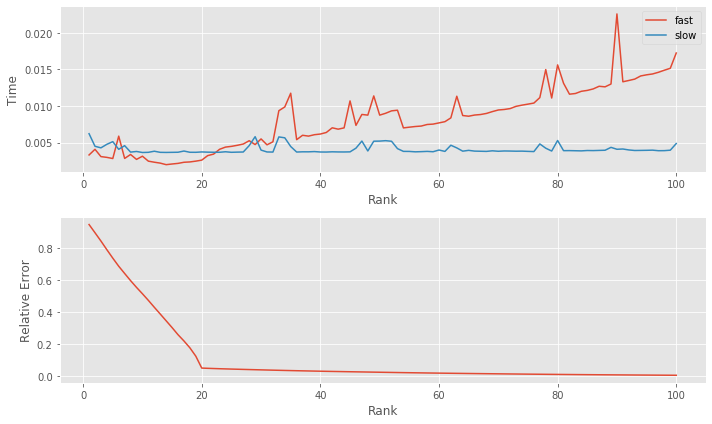

In [77]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

**Commentaires**:

- La méthode rapide est adaptée pour les matrices sparses ou les matrices pour lesquelles seules quelques valeurs propres sont calculées.
- si le temps de calcul est plus court avec la méthode rapide pour un rang k inférieure à 20, ce temps augmente à partir de k >25 et dépasse celui de la méthode lente. Cette dernière reste stable quelque soit le rang.
- L'erreur relative décroit rapidement de 1 vers 0.05 lorsque le rang croît de 0 à 20, puis se stabilise. Le rang de k= 100 doit ếtre atteint afin de s'approcher au mieux de 0.

- si un compromis est nécessaire entre temps de calcul et une erreur satisfaisante, k = 20 semble idéal.

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [78]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    W =  rng.normal(0, 2*gamma, (n_features, c))
    b =  rng.uniform(0, 2*math.pi, (1,c))
    
    X_new_train = np.sqrt(2/c)*np.cos(np.dot(X_train,W)+b)
    X_new_test = np.sqrt(2/c)*np.cos(np.dot(X_test,W)+b)
    
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [80]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

#Fitting non-linear SVC with RKF
print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf_rkf= LinearSVC(dual=False)
clf_rkf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

#Prediction
print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
clf_rkf.predict(Z_test)
print("done in %0.3fs" % (time() - t1))
timing_rkf = time()-t0

#Accuracy
accuracy = clf_rkf.score(Z_test, y_test)
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 0.982s
Predicting with SVC linear on 40000 samples...
done in 0.009s
classification accuracy: 0.934


In [ ]:
ratio_kernel_rkf = str(round(timing_kernel/timing_rkf))

print('Training the model and making predictions with the test set is ' + ratio_kernel_rkf + ' times faster with features selected through the Random Kernel Feature methods than with all the features' )

**Commentaires** : 
-  En utilisant la technique des Random Kernel Features, le temps de calcul sur l'entraînement et la prédiction pour le SVM non linéaire avec noyau Gaussien a été divisé par 8. Cependant il reste légèrement plus élevé que la méthode linéaire utilisée précédemment, ce qui s'explique par le nombre de features à sélectionner : 300

- Les performances sont également inférieures au modèle non linéaire avec noyau Gaussien de départ: 0.046 de différence entre les deux précisions, justifié par la technique de RKF elle-même qui ne calcule qu'une valeur approximative du noyau afin de réduire le temps de calcul.

- Il s'agit encore d'un compromis, mais la perte en performance est satisfaisante pour une telle diminution du temps de calcul   

## Question 6

On implémente la méthode de Nystrom.

In [ ]:


def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    
    rng = np.random.RandomState(seed)
    
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)    
    X_train_idx = X_train[idx, :]     
        
    n_samples_test = X_test.shape[0]
    idx_test = rng.choice(n_samples_test,c)
    X_test_idx = X_test[idx_test,:]
    
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    u,s,vt = svd(W, full_matrices=False)

    W_k = np.dot(u[:,:k], np.dot(np.diag(s[:k]), vt[:k]))
    
    M = np.dot(vt[:k].T, np.diag(1/np.sqrt(s[:k])))
    
    Ctrain = rbf_kernel(X_train,X_train_idx)
    Ctest = rbf_kernel(X_test,X_train_idx)
    
    X_new_train = np.dot(Ctrain,M)
    X_new_test = np.dot(Ctest,M)
    

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [85]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

#Fitting with Nystrom
print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf_nystrom = LinearSVC(dual=False)
clf_nystrom.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

#Predictions
print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
clf_nystrom.predict(Z_test)
print("done in %0.3fs" % (time() - t1))
timing_nystrom=time() - t0

#Accuracy
accuracy = clf_nystrom.score(Z_test, y_test)
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 0.886s
Predicting with SVC linear on 40000 samples...
done in 0.009s
classification accuracy: 0.976


In [89]:
ratio_kernel_nystrom = str(round(timing_kernel/timing_nystrom))
ratio_rkf_nystrom = str(round(timing_rkf/timing_nystrom))

print('Training the model and making predictions with the test set is ' + ratio_kernel_nystrom + ' times faster with features selected through the Nystrom methods than with all the features' )


print('Training the model and making predictions with the test set is ' + ratio_rkf_nystrom + ' times faster with features selected through the Nystrom methods than with RKF' )

Training the model and making predictions with the test set is 9 times faster with features selected through the Nystrom methods than with all the features
Training the model and making predictions with the test set is 1 times faster with features selected through the Nystrom methods than with RKF


In [93]:
##comparing time required to generate features between Nystrom and RKF
t0 = time()
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)
generation_nystrom = time() - t0

t0 = time()
Z_train, Z_test = random_features(X_train, X_test, gamma, c=500, seed=44)
generation_rkf = time() - t0

print('Temps de génération des features via Nystrom : ' + str(round(generation_nystrom,2)) + 'sec' )
print('Temps de génération des features via RKF : ' + str(round(generation_rkf,2)) + 'sec' )

Temps de génération des features via Nystrom : 0.52sec
Temps de génération des features via RKF : 0.18sec


In [94]:
##RKF performance was based on c =300, let's compare it with c = 500 features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=500, seed=44)

#Fitting non-linear SVC with RKF
print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf_rkf= LinearSVC(dual=False)
clf_rkf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

#Prediction
print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
clf_rkf.predict(Z_test)
print("done in %0.3fs" % (time() - t1))
timing_rkf = time()-t0

#Accuracy
accuracy = clf_rkf.score(Z_test, y_test)
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.440s
Predicting with SVC linear on 40000 samples...
done in 0.015s
classification accuracy: 0.942


**Commentaires** : 
- En utilisant la technique de Nystrom, le temps de calcul sur l'entraînement et la prédiction pour le SVM non linéaire avec noyau Gaussien a été divisé par 9.
- Le temps de calcul entre Nystrom et RKF est sensiblement le même
- Cependant le temps pour générer les features est légèrement plus rapide pour RKF
- le modèle de base ayant pour précision 0.98,  les performances du modèle utilisant la technique de Nystrom sont très satisfaisantes : 0.976, contre 0.942 pour le modèle avec RKF (calculé avec 500 features). Pour un même nombre d'observation aléatoire, Nystrom atteint de meilleurs performances

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [97]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_kernel = np.zeros(n_ranks)
timing_linear = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_kernel = np.zeros(n_ranks)
accuracy_linear = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    
    #time and prediction scores for RKF
    t0 = time()
    clf_rkf = LinearSVC(dual = False)
    Z_train,Z_test = random_features(X_train, X_test, gamma, c=c, seed = 2)
    clf_rkf.fit(Z_train,y_train)
    timing_rkf[i] = time() - t0
    accuracy_rkf[i] = clf_rkf.score(Z_test,y_test)
    
    #time and prediction scores for Nystrom
    t0 = time()
    clf_nystrom = LinearSVC(dual=False)
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=2)
    clf_nystrom.fit(Z_train, y_train)
    timing_nystrom[i] = time() - t0
    accuracy_nystrom[i] = clf_nystrom.score(Z_test, y_test)
    
    #time and prediction scores for RBF
    t0 = time()
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    timing_kernel[i] = time() - t0
    accuracy_kernel[i] = clf.score(X_test, y_test)
    
    #time and prediction scores for the linear SVM
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(X_train, y_train)
    timing_linear[i] = time() - t0
    accuracy_linear[i] = clf.score(X_test, y_test)

Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


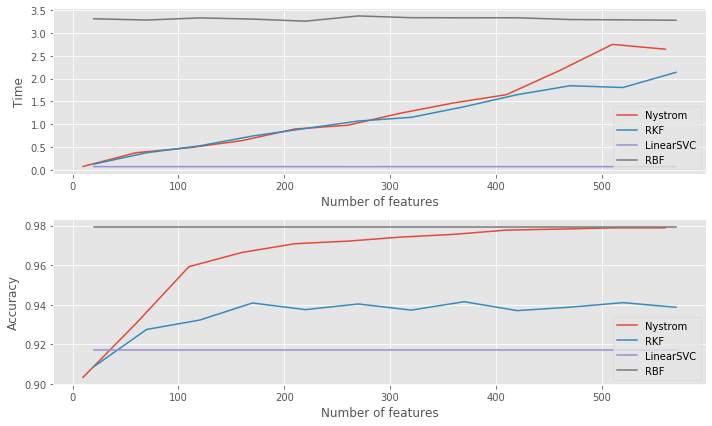

In [98]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()



## Conclusion

- Le modèle linaire est efficace en calcul mais sa performance en prédiction est faible. il ne dépend pas de k et son temps de calcul reste constant, par ailleurs, le nombre de feature est seulement de 22. 
- Le modèle à noyau est le meilleur en prédiction  puisqu'il calcule l'ensemble de la matrice de Gram, mais son temps de calcul est trop important pour un passage à l'échelle. 
- Le modèle de l'approximation de Nystrom, est le plus performant d'un point de vue compromis précision/ temps de calcul. Si il est moin bons aue le modèle linéaire sur de faibles nombres de features, cette précision augmente et devient très proche de celle du modèle à noyau (surtout à k= 400, tout en étant deux fois plus rapides en temps de calcul) 
- Le modèle rkf semble légèrement inférieur à celui de Nystrom, étant équivalent en temps de calcul, mais moins bon en précision.

- Comportement asymptotique :
> Pour **c = 0** , RKF et Nystrom sont équivalent au modèle linéaire pour le temps de calcul \
> Pour **c = 500**, il n'y a plus d'approximation, Nystrom calcule l'ensemble de la matrice de Gram, ce qui explique la convergence vers la précision du modèle à Noyau


 Dans ce TP, le modèle non linéaire avec la technique de Nystrom est le plus performant, mais il est possible de trouver des situations où les autres modèles s'en sortent mieux.